In [1]:
import pandas as pd
import numpy as np
import io
import requests
import seaborn as sn
import matplotlib.pyplot as plt
import calendar
from datetime import datetime


In [38]:
# Download data for september 2020
url="https://data.urbansharing.com/oslobysykkel.no/trips/v1/2019/10.csv"
s = requests.get(url).content
training_data = pd.read_csv(io.StringIO(s.decode('utf-8')))

# Download data for september 2019
url="https://data.urbansharing.com/oslobysykkel.no/trips/v1/2020/10.csv"
s = requests.get(url).content
test_data = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [39]:
# Aggregate the data into more useful classes
training_data["date"] = training_data.started_at.apply(lambda x : x.split()[0])
training_data["hour"] = training_data.started_at.apply(lambda x : x.split()[1].split(":")[0])
training_data["hour"] = pd.to_numeric(training_data["hour"]) # Convert hour column to numbers
training_data["weekday"] = training_data.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
training_data["month"] = training_data.date.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month]) # Future idea is to use season / month to get better prediction data

# Aggregate testing data
test_data["date"] = test_data.started_at.apply(lambda x : x.split()[0])
test_data["hour"] = test_data.started_at.apply(lambda x : x.split()[1].split(":")[0])
test_data["hour"] = pd.to_numeric(test_data["hour"])
test_data["weekday"] = test_data.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])

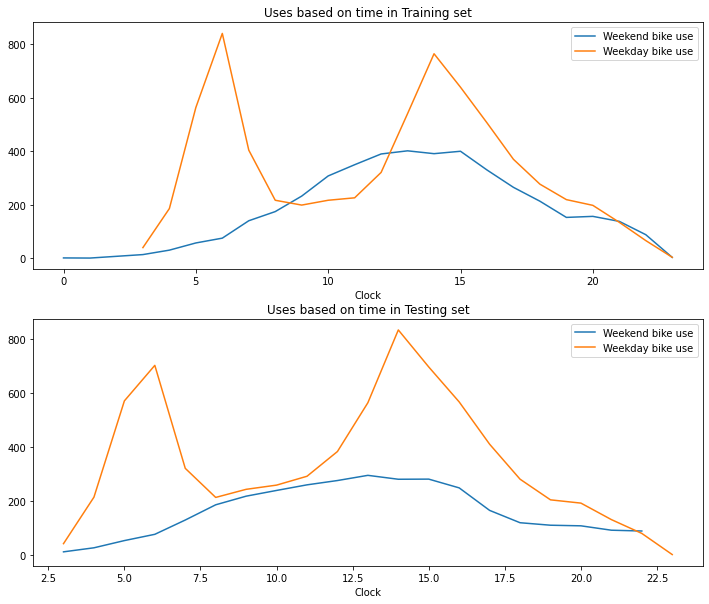

In [40]:
# Visualize testing data use
fig, ax = plt.subplots(2,1)
fig.set_size_inches(12, 10)

ax[0].set(xlabel='Clock',title="Uses based on time in Training set")
# Visualize weekend use of citybikes
hourAggregated_weekends = training_data.loc[training_data["weekday"].isin(["Saturday", "Sunday"])][["hour", "weekday"]]
hourAggregated_weekends.sort_values(["hour"]).groupby(["hour"])
ax[0].plot(hourAggregated_weekends["hour"].value_counts().div(8).sort_index(), label="Weekend bike use")

# Visualize weekday use of citybikes
hourAggregated_weekdays = training_data.loc[~training_data["weekday"].isin(["Saturday", "Sunday"])][["hour", "weekday"]]
hourAggregated_weekdays.sort_values(["hour"]).groupby(["hour"])
ax[0].plot(hourAggregated_weekdays["hour"].value_counts().div(23).sort_index(), label="Weekday bike use")

ax[0].legend()



ax[1].set(xlabel='Clock',title="Uses based on time in Testing set")

# Visualize weekend use of citybikes
hourAggregated_weekends = test_data.loc[test_data["weekday"].isin(["Saturday", "Sunday"])][["hour", "weekday"]]
hourAggregated_weekends.sort_values(["hour"]).groupby(["hour"])
ax[1].plot(hourAggregated_weekends["hour"].value_counts().div(4).sort_index(), label="Weekend bike use")

# Visualize weekday use of citybikes
hourAggregated_weekdays = test_data.loc[~test_data["weekday"].isin(["Saturday", "Sunday"])][["hour", "weekday"]]
hourAggregated_weekdays.sort_values(["hour"]).groupby(["hour"])
ax[1].plot(hourAggregated_weekdays["hour"].value_counts().div(8).sort_index(), label="Weekday bike use")

ax[1].legend()


In [19]:
categoricalFeatureNames = ["date","weekday","hour"]

cleaned_training_data = training_data.loc[(training_data["hour"] > 2)] # Removes data between 0 and 2 since it is negligent, and it does not easily allow one hot encoding 
x_train = cleaned_training_data[categoricalFeatureNames].drop_duplicates()[["weekday","hour"]]
y_train = cleaned_training_data[categoricalFeatureNames].value_counts().sort_index()
y_train = y_train.tolist()

cleaned_test_data = test_data.loc[(test_data["hour"] > 2)] # Removes data between 0 and 2 since it is negligent, and it does not easily allow one hot encoding 
x_test = cleaned_test_data[categoricalFeatureNames].drop_duplicates()[["weekday","hour"]]
y_test = cleaned_test_data[categoricalFeatureNames].value_counts().sort_index()
y_test = y_test.tolist()


# One hot encoding
x_train = pd.concat([pd.get_dummies(x_train.weekday), pd.get_dummies(x_train.hour)], axis=1)

x_test = pd.concat([pd.get_dummies(x_test.weekday), pd.get_dummies(x_test.hour)], axis=1)

print(x_test.head())


      Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday  3  4  5  \
0          0       0         0       0         1        0          0  1  0  0   
46         0       0         0       0         1        0          0  0  1  0   
331        0       0         0       0         1        0          0  0  0  1   
1087       0       0         0       0         1        0          0  0  0  0   
2013       0       0         0       0         1        0          0  0  0  0   

      ...  14  15  16  17  18  19  20  21  22  23  
0     ...   0   0   0   0   0   0   0   0   0   0  
46    ...   0   0   0   0   0   0   0   0   0   0  
331   ...   0   0   0   0   0   0   0   0   0   0  
1087  ...   0   0   0   0   0   0   0   0   0   0  
2013  ...   0   0   0   0   0   0   0   0   0   0  

[5 rows x 28 columns]


In [48]:
import math
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.1)

# Train the model
gbm.fit(x_train,y_train)

# Make predictions
preds = gbm.predict(x_test)



# evaluate model numerically
print("R^2 coefficient on training data", gbm.score(x_train,y_train)) # Returns the coefficient of determination R^2 of the prediction.
print("R^2 coefficient on testing data", gbm.score(x_test,y_test))

# Looks at error
print("Mean square error on test data is: ", mean_squared_error(y_test,preds))
print("Mean absolute error is:", mean_absolute_error(y_test,preds))

print("\n The following shows some of the differences between predicted value and actual value on test set")
for i in range(len(preds)//5):
    index_diffs.append(i)
    differences.append(y_test[i]-preds[i])
    print("PRED:",math.floor(preds[i]),"    REAL:",y_test[i])

R^2 coefficient on training data 0.8040491904993856
R^2 coefficient on testing data 0.7786443880032972
Mean square error on test data is:  11487.428420366099
Mean absolute error is: 73.82010793119503

 The following shows the differences between predicted value and actual value on test set
PRED: 50     REAL: 46
PRED: 235     REAL: 285
PRED: 756     REAL: 756
PRED: 982     REAL: 926
PRED: 402     REAL: 445
PRED: 228     REAL: 286
PRED: 208     REAL: 318
PRED: 257     REAL: 326
PRED: 235     REAL: 340
PRED: 337     REAL: 415
PRED: 560     REAL: 618
PRED: 786     REAL: 978
PRED: 565     REAL: 822
PRED: 482     REAL: 689
PRED: 330     REAL: 514
PRED: 237     REAL: 340
PRED: 189     REAL: 280
PRED: 174     REAL: 316
PRED: 123     REAL: 132
PRED: 54     REAL: 65
PRED: 46     REAL: 44
PRED: 192     REAL: 187
PRED: 611     REAL: 517
PRED: 923     REAL: 689
PRED: 364     REAL: 368
PRED: 221     REAL: 264
PRED: 232     REAL: 298
PRED: 242     REAL: 314
PRED: 279     REAL: 372
PRED: 405     REAL:

In [49]:
# Make prediction data ready for visualization
test_visualize = cleaned_test_data[categoricalFeatureNames].drop_duplicates()[["weekday","hour"]]
test_visualize["predicted"] = preds

test_visualize_weekend = test_visualize.loc[test_visualize["weekday"].isin(["Saturday", "Sunday"])]

test_visualize_weekdays = test_visualize.loc[~test_visualize["weekday"].isin(["Saturday", "Sunday"])]


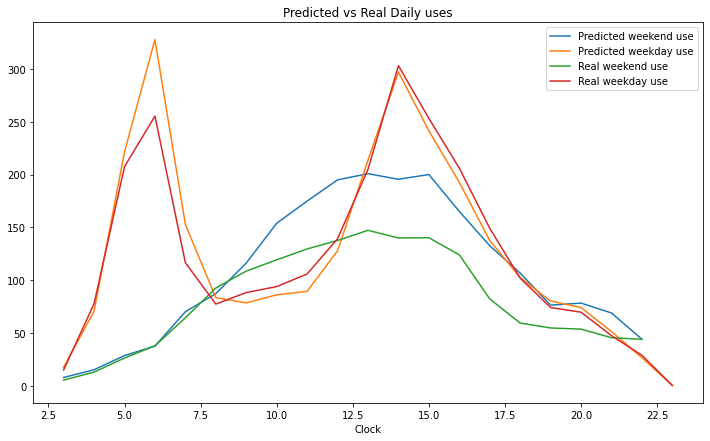

In [50]:
# Evaluate model visually
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12, 7)
ax.set(xlabel='Clock',title="Predicted vs Real Daily uses")

# Plot predicted use
ax.plot(test_visualize_weekend.groupby(["hour"]).sum().div(8), label="Predicted weekend use")
ax.plot(test_visualize_weekdays.groupby(["hour"]).sum().div(22), label="Predicted weekday use")


# Plot actual use
ax.plot(hourAggregated_weekends["hour"].value_counts().div(8).sort_index(), label="Real weekend use")
ax.plot(hourAggregated_weekdays["hour"].value_counts().div(22).sort_index(), label="Real weekday use")

ax.legend()